# Agent Chat User Interface

LangGraph recently addeed an easy-to-use User Interface for our agents. It can be used with any graph - or at least it looks like it - so why don't we try using it? 

Resources:
- [yt tutorial](https://youtu.be/SMuOVOG-cjA?si=xLV12uZxDJaia8Bz)
- [`agent-chat-ui` repository](https://github.com/langchain-ai/agent-chat-ui)
- [LangGraph CLI](https://langchain-ai.github.io/langgraph/cloud/reference/cli/#langgraph-cli)
- [LangGraph Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#langgraph-studio)

## Build Our Custom Agent

First we need to build our custom agent. We will use a simplified version of RAGV4.1 (an agent supervisor coordinating a data analyst and a visualzier) from on my personal projects. We will just have the supervisor and the analyst, which will only load data. 

Let's make all the imports

In [1]:
# Standard library
import os
from pathlib import Path
from typing import Union, Dict
from typing_extensions import Annotated

# Third-party libraries
import pandas as pd
import geopandas as gpd

# LangChain and LangGraph
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import MessagesState
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


DATASET_FOLDER = "./LLM_data"

We want to load our API keys: I'll use OpenAI in this example, so we will jsut set that up in our `UI.env` file, together with a LangSmith API key (this is not needed, but it's nice to have it set up - still you can do everything without LangSmith).

In [ ]:
# setup keys

import getpass
import os
from dotenv import load_dotenv
from pathlib import Path

env_name = "UI"  
env_path = Path("envs") / f"{env_name}.env"

load_dotenv(dotenv_path=env_path)

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGSMITH_API_KEY")

### reducer and state_schema

In [2]:
def merge_dictionary_entries(existing_dict: Union[dict, None] = None, new_dict: Union[dict, None] = None) -> dict:
    """
    Custom reducer to merge dictionary updates:
    adds keys from new_dict only if they are not already in existing_dict.
    """

    if not existing_dict:
        existing_dict = {}
    if not new_dict:
        new_dict = {}

    for key, data in new_dict.items():
        if key not in existing_dict:
            existing_dict[key] = data
    
    return existing_dict

In [3]:
class DatasetState(MessagesState):
    loaded: Annotated[Dict[str, Union[pd.DataFrame, gpd.GeoDataFrame]], merge_dictionary_entries]
    descriptions: Annotated[Dict[str, str], merge_dictionary_entries]
    remaining_steps: int

### tools

In [4]:
# ----------------------
# Tool: list datasets
# ----------------------
@tool
def list_loadable_datasets() -> str:
    """Lists all available parquet datasets in the dataset folder."""
    files = [f for f in os.listdir(DATASET_FOLDER) if f.endswith(".parquet")]
    return "\n".join(files) if files else "No parquet datasets found."

@tool
def list_inmemory_datasets(state: Annotated[DatasetState, InjectedState]) -> str:
    """Lists all loaded datasets and their type (DataFrame or GeoDataFrame)."""
    if not state["loaded"]:
        return "No loaded datasets in memory. Use list_loadable_datasets() to see available files."
    
    lines = []
    for name, df in state["loaded"].items():
        dtype = "GeoDataFrame" if isinstance(df, gpd.GeoDataFrame) else "DataFrame"
        lines.append(f"- {name}: {dtype} (shape={df.shape})")

    return "\n".join(lines)

# ----------------------
# Tool: load datasets
# ----------------------
@tool
def load_dataset(file_name: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> Command:
    """
    Loads a Parquet dataset (optionally as GeoDataFrame) and updates state['loaded'][name].
    """
    update = {}

    file_stem = Path(file_name).stem
    file_name = f"{file_stem}.parquet"
    path = Path(DATASET_FOLDER) / file_name

    if not path.exists():
        return f"File '{file_name}' not found."

    try:
        df = pd.read_parquet(path)
        if "geometry" in df.columns:
            try:
                df = gpd.read_parquet(path)
            except Exception as geo_err:
                return f"Failed to load as GeoDataFrame: {geo_err}"
        update[file_stem] = df
    except Exception as e:
        return f"Error loading dataset: {e}"

    return Command(update={
        "loaded": update,   
        "messages": [
            ToolMessage(f"Loaded dataset '{file_stem}' into memory.", tool_call_id=tool_call_id)
        ]
    })

### worker

In [5]:
prompt = (
    "You are a data analyst. Use your tools to explore and load datasets relevant to the task.\n"
    "The files you need to load are in the subdirectory at ./LLM_data\n"
    "Datasets are stored as `file_name.parquet`\n\n"
    "You can check which datasets are currently loaded with the `list_inmemory_datasets()` tool, \
    and which datasets are available to load using the `list_loadable_datasets()` tool.\n\n"
)

In [6]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

model = "openai:gpt-4o-mini"

analyst_agent = create_react_agent(
    model=model,  # (!) OpenAI will use parallel tool calls by default - fine since we have a custom reducer
    tools=[list_loadable_datasets,
           list_inmemory_datasets, 
           load_dataset],
    prompt=prompt,
    name="data_analyst",
    state_schema=DatasetState
)

### supervisor

In [7]:
supervisor_prompt = (
    "You are coordinating a data analyst \n\n"
    "When the data analyst finishes its work, you can end the workflow.\n"
    "Do not do any work yourself.\n"
)

In [8]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-3.5-turbo"),    
    agents=[analyst_agent],
    prompt=supervisor_prompt,
    state_schema=DatasetState,  # (!) don't forget this
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

### graph structure

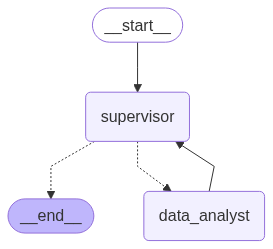

In [9]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

## User Interface

We need the `langgraph-cli` package to continue:

In [ ]:
%pip install langgraph-cli -q -U

We also need to write a `langgraph.json` file in our directory. We can add many features to the CLI, but the basics are enough for now, so we'll just have the json with:

```
{
  "dependencies": ["."],
  "graphs": {
    "chat": "./chat/graph.py:graph"
  }
}
```

Ok, now the important stuff: this UI has no integration with jupyter notebooks. So we need to refactor the code into files: we'll do that inside the `AgentChatUI/` folder. 

Also, and this is the very jey point, we need to **make our code a python project**. Otherwise the `langgraph dev` command won't execute. 

There are some steps to follow in order to do so:

-----

### **Steps to Structure Your LangGraph Project as a Python Package**

-----

#### 1. Put All Your Code in a Package Folder

Create a dedicated folder (e.g., `agent_ui/`) that contains all your Python code.
Include an `__init__.py` file to mark it as a package (it can be empty).

**Example structure:**

```
project-root/
├── agent_ui/
│   ├── __init__.py
│   ├── state.py
│   ├── tools.py
│   ├── supervisor.py
│   └── ...
├── langgraph.json
└── pyproject.toml
```

---

#### 2. Create a `pyproject.toml` File in the Root

```toml
[project]
name = "agent_ui"
version = "0.1.0"
description = "LangGraph agent project"
dependencies = []

[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"
```

---

#### 3. Install the Project in Editable Mode

From the root directory, run:

```bash
pip install -e .
```

This allows Python (and LangGraph CLI) to resolve imports correctly.

---

#### 4. Use Absolute Imports Within the Package

Instead of local imports like:

```python
from state import DatasetState
```

Use:

```python
from agent_ui.state import DatasetState
```

---

#### 5. Update `langgraph.json` to Point to the Correct Graph

```json
{
  "dependencies": ["."],
  "graphs": {
    "chat": "agent_ui.supervisor:supervisor"
  }
}
```

This tells LangGraph CLI to look for the compiled graph in your package.

---

#### 6. Run LangGraph Dev Server

From the root:

```bash
langgraph dev 
```


-----

Once this is working, we will get a link to a browser window where our graph is running!